This file will be to make figure 1 or the triangle plot from Sen 2015. We need to do the following steps to produce this plot:
1. Select systems of interest - in our case these are binary white dwarfs
2. Select the masses of these systems were M1>M2
3. Make a skeleton plot of the triangle plot but setting mass and stellar type bounds
4. Make a 2D histogram or density plot the includes redshift information (at a sepcific redshift or over all redshifts)

### 1. Selecting Systems of Interest

In [2]:
# let's import things
import h5py as h5 
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text.latex', preamble=r'\usepackage{textgreek}')
plt.rc('font', family='serif')
import sys
import os
from scipy import stats
import seaborn as sns
import matplotlib as mpl

# Add the subdir to sys.path
sys.path.append('/home/jovyan/home/research_work/useful_py_scripts/')

# Now you can import the module
import useful_fncs 

# import for axes labels 
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})

In [3]:
# now let's make a bool or use numpy.isin to select for BWDs
# let's test out how it works with random arrays
# first let's make a random list
test_list = np.array([3, 11, 10, 4, 5])
# let's specify the criteria we want to identify in the list (similar to how we want to select a certain stellar type from a list)
criteria_match = [10,11]

# creating the mask and specifying which elements of the list agree or do not agree with the criteria
mask = np.isin(test_list, criteria_match)

# selecting only the elements that agree
test_list[mask]

array([11, 10])

In [3]:
# reading in the HDF5 file
pathToweights_H5 = '/home/jovyan/home/copy_h5_files/v03.08.01/CEalpha1/N1e6_MassiveWDWD_NSNS_CEalpha1_fbinNone.h5' #path of the hdf5 file

Data_weights = h5.File(pathToweights_H5,"r")

# let's gather the system parameters group 
SP_WD_data = pd.DataFrame() # making a pandas dataframe

for key in Data_weights["BSE_Double_Compact_Objects"].keys(): #looping through the "keys" or paramters in BSE_System_Parameters

    SP_WD_data[key] = Data_weights["BSE_Double_Compact_Objects"][key][()] # adding these columns to the dataframe

# Rates info directly taking out the 
# merger_SEED = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['SEED'][()]
rates_DCO = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate'][()]
rates_z0_DCO = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate_z0'][()]
DCO_mask = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['DCOmask'][()]
redshifts = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['redshifts'][()]
# rates_info = Data_weights["Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048"]

Data_weights.close()

In [4]:
# let's try selecting all systems with white dwarfs now using the np.isin technique

# WDWD_mask = np.logical_and(np.isin(SP_WD_data['Stellar_Type(1)'],[10,11,12]),np.isin(SP_WD_data['Stellar_Type(2)'],[10,11,12]))
SP_DCO_DATA = SP_WD_data[DCO_mask]

# let's make sure that at least one of these white dwarfs are COWD
HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool = useful_fncs.WD_BINARY_BOOLS(SP_DCO_DATA)
carbon_oxygen_bool = np.logical_or(ONeCOWD_bool,np.logical_or(COONeWD_bool,np.logical_or(COHeWD_bool,np.logical_or(COWD_bool,HeCOWD_bool))))
SP_COWD_DATA = SP_DCO_DATA[carbon_oxygen_bool]

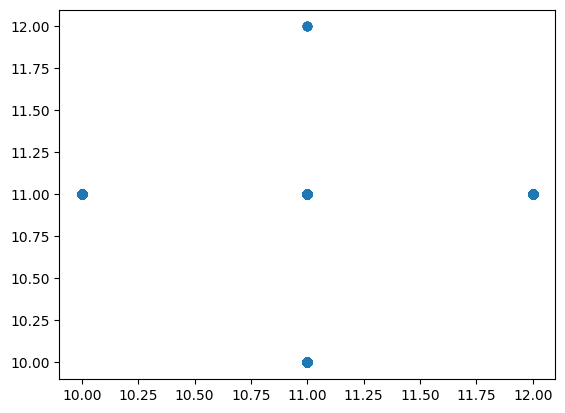

In [5]:
# making sure these are just WDWD systems
plt.scatter(SP_COWD_DATA['Stellar_Type(1)'],SP_COWD_DATA['Stellar_Type(2)'])

### 2. Select the Masses of these Systems

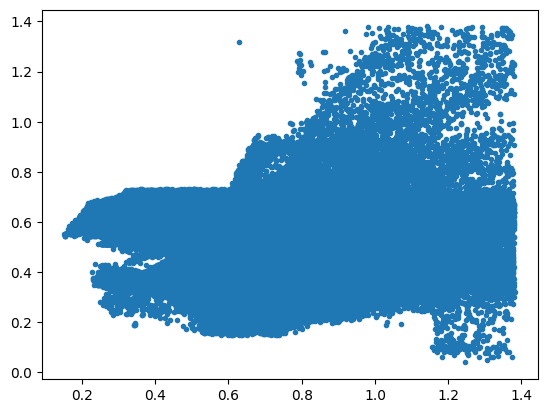

In [6]:
Mass1 = np.array(SP_COWD_DATA['Mass(1)'])
Mass2 = np.array(SP_COWD_DATA['Mass(2)'])
plt.plot(Mass1, Mass2, '.')

### 3. Make a Skeleton Plot

In [7]:
# making sure m1 is referring to the more massive object
M1 = np.maximum(Mass1,Mass2)
M2 = np.minimum(Mass1, Mass2)
# # we need to make sure that we are only selecting for M1 that is larger than M2, this is only needed if we are not dealing with a datatframe
# M1 = []
# M2 = []
# for i in range(len(Mass1)):
#     if Mass1[i]>Mass2[i]:
#         M1.append(Mass1[i])
#     if Mass2[i]<Mass1[i]:
#         M2.append(Mass2[i])

Text(0, 0.5, '$M_{2}/M_{\\odot}$')

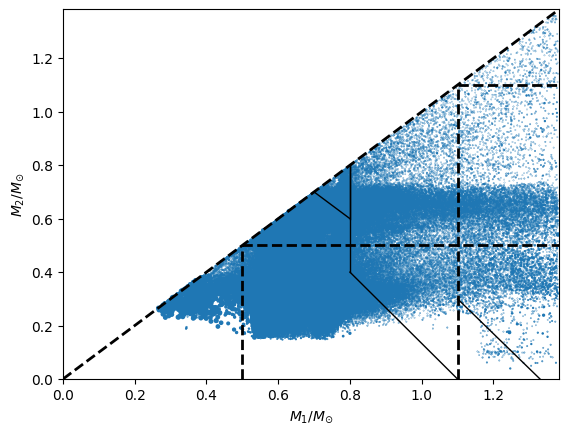

In [7]:
# let's plot the masses
plt.scatter(M1,M2,s=SP_COWD_DATA['mixture_weight'])

# let's add the restrictive lines to the plot
# there should be no plots in the upper left triangle because M1>M2

plt.axline((0,0), (max(M1),max(M1)), color="black", ls='--', lw = 2, transform=plt.gca().transAxes)

xlim = max(M1)
ylim = max(M1)

# let's add the mass restrictions for each case of BWD
#Helium WD cutoff
plt.vlines(x=[0.5], ymin=0, ymax=0.5, colors='black', ls='--', lw=2)
plt.axhline(y=0.5, color='black', xmin = 0.5/xlim, xmax = max(M1)/xlim, ls='--', lw=2) # for axhline, the xmin and mxmax are scale factors of the axis not positions
#Carbon oxygen WD cutoff
plt.vlines(x=[1.1], ymin=0, ymax=1.1, colors='black', ls='--', lw=2)
plt.axhline(y=1.1, color='black', xmin = 1.1/xlim, xmax = max(M1)/xlim, ls='--', lw=2)

# let's now added a shaded area that corresponds to what is confidently perscribed as being a Type Ia SN by Shen 2015
# purple shaded SN Ia
p1 = plt.plot([0.7,0.8],[0.7,0.6],color='black',lw=1)
p2 = plt.plot([0.8,0.8],[0.6,0.8],color='black',lw=1)

p3 = plt.plot([1.1,1.33],[0.3,0],color='black',lw=1)

# plt.fill_between([0.7,0.8], 
#                 p1,
#                 p2,
#                 where=(p2>p1), 
#                 alpha=0.15, 
#                 color="purple")#,label=r'LVK BNS Rate $\mathrm{z=0.2}$')

# orange SNe Ia
o1 = plt.plot([0.8,1.1],[0.4,0], color ='black',lw=1)
o2 = plt.plot([0.8,0.8],[0.4,0.8],color='black',lw=1)

# setting the limits of the plot
plt.xlim(0,xlim)
plt.ylim(0,ylim)

# axes labels
plt.xlabel("$M_{1}/M_{\odot}$")
plt.ylabel("$M_{2}/M_{\odot}$")

### 4. Make a 2D Histogram

Text(0, 0.5, 'Merger Rate [$\\mathrm{dNdGpc^{-3}dyr^{-1}]M_{\\odot}^{-1}}$')

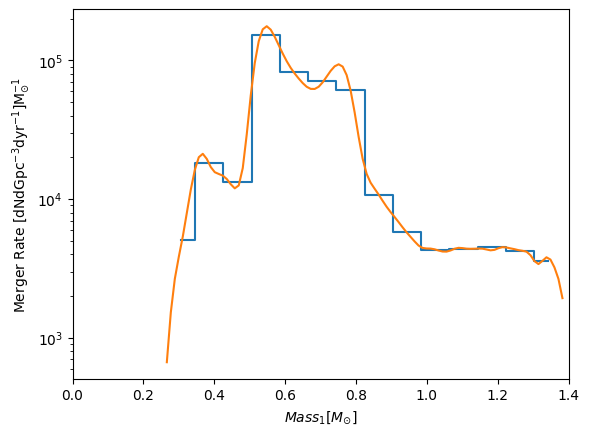

In [10]:
# before making the density plot we need to gather the merger rate for these systems at every redshift
# Rates info for Z = 0
WDWD_merger_rate_Z0 = rates_z0_DCO[carbon_oxygen_bool]

# let's start with just a normal histogram so we know we understand how the weights are working

hist_mass1, bin_edges_mass1 = np.histogram(M1,weights=WDWD_merger_rate_Z0,bins=np.linspace(min(M1),max(M1),15))
center_bins_mass1 = (bin_edges_mass1[:-1] + bin_edges_mass1[1:])/2
bin_width_mass1 = np.diff(bin_edges_mass1)
# can also do plt.plot with drawstyle = 'steps' of 'steps-mid'
plt.step(center_bins_mass1,hist_mass1/bin_width_mass1, where='mid')#/sum(hist_mass1), where='mid') # are these units of counts/width? is that the same counts/mass?
# to normalize this function so that the sum of the area under the curve adds up to one, we can divide by the sum of the histogram counts, divide
# plt.yscale('log')

# adding a KDE
kernel = stats.gaussian_kde(M1,bw_method=.1,weights=WDWD_merger_rate_Z0)
# bw - kind of like the bin width (bw) method from before but a way of how to draw gaussians on top of each point (to then sum them up later)
# we now want to atually draw the kernel
x_KDE = np.linspace(min(M1),max(M1),100) # to make KDE more smooth and not jagged like the histogram
KDEy_vals = kernel(x_KDE)*sum(hist_mass1) # we need to either unnormalize the kernel or normalize the histogram to make this work, if er sum(histgram counts) we can match shape of other histogram, multiply
plt.plot(x_KDE,KDEy_vals)
plt.yscale('log')
plt.xlim(0,1.4)

plt.xlabel(r"$Mass_{1}$[$M_{\odot}$]") 
plt.ylabel(r"Merger Rate [$\mathrm{dNdGpc^{-3}dyr^{-1}]M_{\odot}^{-1}}$")


Text(0, 0.5, 'Merger Rate [$\\mathrm{dNdGpc^{-3}dyr^{-1}]M_{\\odot}^{-1}}$')

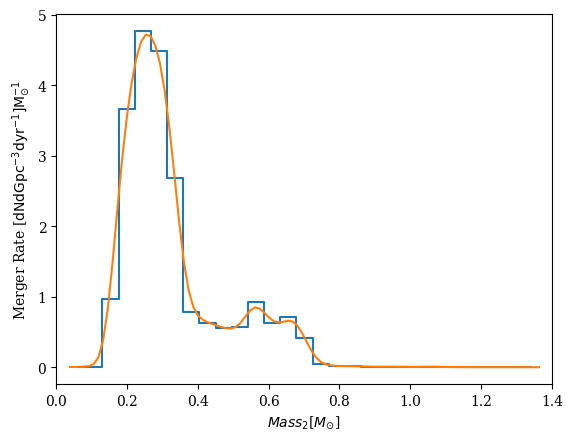

In [ ]:
# before making the density plot we need to gather the merger rate for these systems at every redshift
# Rates info for Z = 0
WDWD_merger_rate_Z0 = rates_z0_DCO[carbon_oxygen_bool]

# let's start with just a normal histogram so we know we understand how the weights are working

hist_mass2, bin_edges_mass2 = np.histogram(M2,weights=WDWD_merger_rate_Z0,bins=np.linspace(min(M2),max(M2),30))
center_bins_mass2 = (bin_edges_mass2[:-1] + bin_edges_mass2[1:])/2
bin_width_mass2 = np.diff(bin_edges_mass2)
# can also do plt.plot with drawstyle = 'steps' of 'steps-mid'
plt.step(center_bins_mass2,hist_mass2/bin_width_mass2/sum(hist_mass2), where='mid') # are these units of counts/width? is that the same counts/mass?
# to normalize this function so that the sum of the area under the curve adds up to one, we can divide by the sum of the histogram counts, divide
# plt.yscale('log')

# adding a KDE
kernel = stats.gaussian_kde(M2,bw_method='scott',weights=WDWD_merger_rate_Z0)
# bw - kind of like the bin width (bw) method from before but a way of how to draw gaussians on top of each point (to then sum them up later)
# we now want to atually draw the kernel
x_KDE = np.linspace(min(M2),max(M2),100) # to make KDE more smooth and not jagged like the histogram
KDEy_vals = kernel(x_KDE) # we need to either unnormalize the kernel or normalize the histogram to make this work, if er sum(histgram counts) we can match shape of other histogram, multiply
plt.plot(x_KDE,KDEy_vals)
plt.xlim(0,1.4)

plt.xlabel(r"$Mass_{2}$[$M_{\odot}$]") 
plt.ylabel(r"Merger Rate [$\mathrm{dNdGpc^{-3}dyr^{-1}]M_{\odot}^{-1}}$")


Let's now step it up to the 2D histogram

Text(0, 0.5, '$M_{2}$[$M_{\\odot}$]')

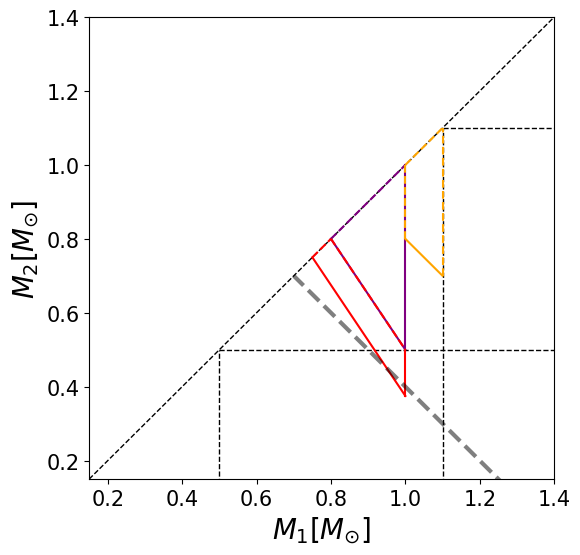

In [8]:
# change figuresize
fig, ax = plt.subplots(figsize = (6,6))

max_mass_lim = 1.4
plt.ylim(0.15,max_mass_lim)
plt.xlim(0.15,max_mass_lim)

# let's add the mass restrictions for each case of binary WDs as prompted by Shen 2025

xlim = max(M1)
ylim = max(M1)

linecolors = 'black'
linewidths = 1

plt.axline((0,0), (max(M1),max(M1)), color=linecolors, ls='--', lw=linewidths, transform=plt.gca().transAxes)

#Helium WD cutoff
plt.vlines(x=[0.5], ymin=0, ymax=0.5, colors=linecolors, ls='--', lw=linewidths) # vertical line
plt.plot([0.5,max_mass_lim],[0.5,0.5],color=linecolors,lw=linewidths, ls='--') # horizontal line

#Carbon oxygen WD cutoff
plt.vlines(x=[1.1], ymin=0, ymax=1.1, colors=linecolors, ls='--', lw=linewidths) # vertical line
plt.plot([1.1,max_mass_lim],[1.1,1.1],color=linecolors,lw=linewidths, ls='--') # horizontal line

# purple region - 2 star SN Ia
xp = [0.8,1.0]
xp = np.array(xp, dtype=float)
p1 = plt.plot(xp,[0.8,0.5],color='purple') # bottom boundary
p2 = plt.plot([1.0,1.0],[1.0,0.5],color='purple') # side boundary
p3 = plt.plot(xp,[0.8,1.0],color='purple',ls='--') # top boundary
# plt.fill_between(xp, p1, p2, where = (p2 < p3), color='purple')

# red region - hypervelocity WDs
plt.plot([0.8,1],[0.8,0.5],color='red',ls='--') # overlapping boundary
plt.plot([0.75,1.0],[0.75,0.375],color='red') # bottom boundary
plt.plot([1.0,1.0],[0.5,0.375],color='red') # side boundary
plt.plot([0.75,0.8],[0.75,0.8],color='red',ls='--') # top boundary
plt.plot([1.1,1.1],[0.7,1.1],color='orange',ls='--') # left side boundary 

# orange region - 2003fg HVS
plt.plot([1.0,1.1],[0.8,0.7],color='orange') # botton boundary
plt.plot([1.0,1.0],[1.0,0.8],color='orange',ls='--') # left side overlapping boundary
plt.plot([1.0,1.1],[1.0,1.1],color='orange',ls='--') # top boundary

# # chandrasekar mass line
plt.plot((1.4,0.7),(0,0.7),color='black', lw=3, ls='--', alpha = 0.5)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("$M_{1}$[$M_{\odot}$]",fontsize=20)
plt.ylabel("$M_{2}$[$M_{\odot}$]",fontsize=20)

# increase tick label sizes

## save figure:
# plt.savefig("WDWD_regions_Shen2025criteria.png",bbox_inches='tight',pad_inches=0.1)

Below is sample code for making a discrete color bar in python from matplotlib

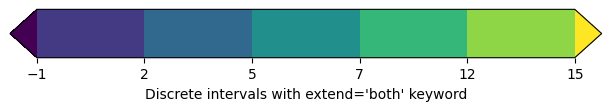

In [27]:
fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')

cmap = mpl.cm.viridis
bounds = [-1, 2, 5, 7, 12, 15]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword")

In [13]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

1.2000530189020801e-06 3251.899710134373


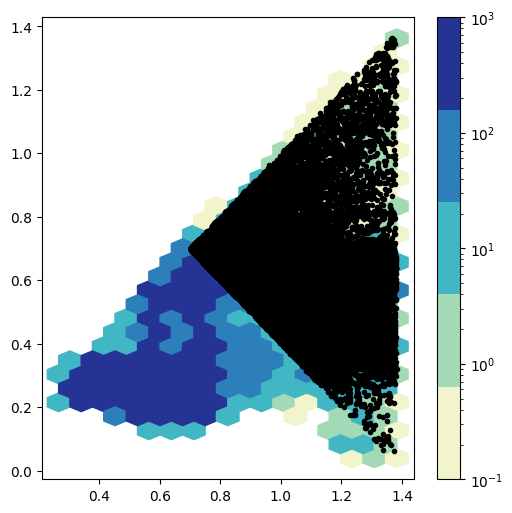

In [14]:
# change figuresize
fig, ax = plt.subplots(figsize = (6,6))

vmin = 10**-1
vmax = 10**3
WDWD_merger_rate_Z0 = rates_z0_DCO[carbon_oxygen_bool]
colors = ["#F2F4CB", "#a1dab4", "#41b6c4", "#2c7fb8", "#253494"]

# for 2D histogram or 2D plots, we need to use somethign that will allow us to use a color bar so something liek pcolormesh or plt.contour or hexbin
hb = plt.hexbin(M1,M2,C=WDWD_merger_rate_Z0,gridsize=(15,15),reduce_C_function = np.sum,
                cmap=ListedColormap(colors),norm='log',vmin=vmin,vmax=vmax) # C is value of weights, 1e3- 10**3
                # use symlog when you also want to cover negative values    
# right now we are not dividing by the bin size, so when we chage the bins - it changes the shape of our dist 
zvalue_array = hb.get_array() # the merger rates of the histigram
print(min(zvalue_array),max(zvalue_array)) # helps us detemine what vim and vmax should be and what the bin size should be 

# # chandrasekar mass line
mchan_bool = np.where(M1 + M2 > 1.4)
plt.plot(M1[mchan_bool],M2[mchan_bool],'.',color='black')

# colorbar
cb = plt.colorbar()
# # cb.set_label(label=r"Merger Rate at z =0 [$\mathrm{dNdGpc^{-3}dyr^{-1}}$]", fontsize = 20)

1.2000530189020801e-06 3251.899710134373


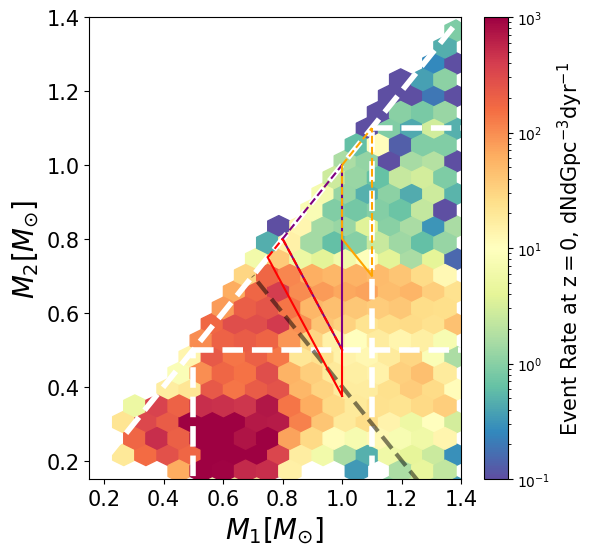

In [ ]:
# change figuresize
fig, ax = plt.subplots(figsize = (6,6))

# let's define a few things first
WDWD_merger_rate_Z0 = rates_z0_DCO[carbon_oxygen_bool]
vmin = 10**-1
vmax = 10**3

# for 2D histogram or 2D plots, we need to use somethign that will allow us to use a color bar so something liek pcolormesh or plt.contour or hexbin
hb = plt.hexbin(M1,M2,C=WDWD_merger_rate_Z0, gridsize=(15,15), reduce_C_function = np.sum, 
                cmap=sns.color_palette("Spectral_r",as_cmap=True),norm='log',vmin=vmin,vmax=vmax) # C is value of weights, 1e3- 10**3
                # use symlog when you also want to cover negative values    
# right now we are not dividing by the bin size, so when we chage the bins - it changes the shape of our dist 
zvalue_array = hb.get_array() # the merger rates of the histigram
print(min(zvalue_array),max(zvalue_array)) # helps us detemine what vim and vmax should be and what the bin size should be 

# colorbar
cb = plt.colorbar()
cb.set_label(label="Event Rate at $\mathrm{z =0}$, $\mathrm{dNdGpc^{-3}dyr^{-1}}$", fontsize = 15)

max_mass_lim = 1.4
plt.ylim(0.15,max_mass_lim)
plt.xlim(0.15,max_mass_lim)

# let's add the mass restrictions for each case of binary WDs as prompted by Shen 2025

xlim = max(M1)
ylim = max(M1)

linecolors = 'white'
linewidths = 4

plt.axline((0,0), (max(M1),max(M1)), color=linecolors, ls='--', lw=linewidths, transform=plt.gca().transAxes)

#Helium WD cutoff
plt.vlines(x=[0.5], ymin=0, ymax=0.5, colors=linecolors, ls='--', lw=linewidths) # vertical line
plt.plot([0.5,max_mass_lim],[0.5,0.5],color=linecolors,lw=linewidths, ls='--') # horizontal line

#Carbon oxygen WD cutoff
plt.vlines(x=[1.1], ymin=0, ymax=1.1, colors=linecolors, ls='--', lw=linewidths) # vertical line
plt.plot([1.1,max_mass_lim],[1.1,1.1],color=linecolors,lw=linewidths, ls='--') # horizontal line

# purple region - 2 star SN Ia
plt.plot([0.8,1],[0.8,0.5],color='purple') # bottom boundary
plt.plot([1.0,1.0],[1.0,0.5],color='purple') # side boundary
plt.plot([0.8,1.0],[0.8,1.0],color='purple',ls='--') # top boundary 

# # chandrasekar mass line
plt.plot((1.4,0.7),(0,0.7),color='black', lw=3, ls='--', alpha = 0.5)


# red region - hypervelocity WDs
plt.plot([0.8,1],[0.8,0.5],color='red',ls='--') # overlapping boundary
plt.plot([0.75,1.0],[0.75,0.375],color='red') # bottom boundary
plt.plot([1.0,1.0],[0.5,0.375],color='red') # side boundary
plt.plot([0.75,0.8],[0.75,0.8],color='red',ls='--') # top boundary
plt.plot([1.1,1.1],[0.7,1.1],color='orange',ls='--') # left side boundary 

# orange region - 2003fg HVS
plt.plot([1.0,1.1],[0.8,0.7],color='orange') # botton boundary
plt.plot([1.0,1.0],[1.0,0.8],color='orange',ls='--') # left side overlapping boundary
plt.plot([1.0,1.1],[1.0,1.1],color='orange',ls='--') # top boundary



plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("$M_{1}$[$M_{\odot}$]",fontsize=20)
plt.ylabel("$M_{2}$[$M_{\odot}$]",fontsize=20)

# increase tick label sizes

## save figure:
# plt.savefig("./figures/triangle_plots/triangle_CEalpha1.pdf",bbox_inches='tight',pad_inches=0.1)

In [29]:
# let's make a function so that we can read in multiple compas variations at once 

def mass_merger_rates(pathToweights_H5):

    # we first need to gather the information for the file of interest
    # reading in the HDF5 file
    Data_weights = h5.File(pathToweights_H5,"r")

    # let's gather the system parameters group 
    SP_WD_data = pd.DataFrame() # making a pandas dataframe

    for key in Data_weights["BSE_Double_Compact_Objects"].keys(): #looping through the "keys" or paramters in BSE_System_Parameters

        SP_WD_data[key] = Data_weights["BSE_Double_Compact_Objects"][key][()] # adding these columns to the dataframe

    # Rates info directly taking out the 
    # merger_SEED = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['SEED'][()]
    # rates_DCO = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate'][()]
    rates_z0_DCO = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['merger_rate_z0'][()]
    DCO_mask = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['DCOmask'][()]
    # redshifts = Data_weights['Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048']['redshifts'][()]
    # rates_info = Data_weights["Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048"]

    Data_weights.close()


    #let's next make sure that we are selecting for WD+WD systems
    SP_DCO_DATA = SP_WD_data[DCO_mask]

    # let's make sure that at least one of these white dwarfs are COWD
    HeWD_bool,COWD_bool,ONeWD_bool,HeCOWD_bool,HeONeWD_bool,COHeWD_bool,COONeWD_bool,ONeHeWD_bool,ONeCOWD_bool = useful_fncs.WD_BINARY_BOOLS(SP_DCO_DATA)
    carbon_oxygen_bool = np.logical_or(ONeCOWD_bool,np.logical_or(COONeWD_bool,np.logical_or(COHeWD_bool,np.logical_or(COWD_bool,HeCOWD_bool))))
    SP_COWD_DATA = SP_DCO_DATA[carbon_oxygen_bool]

    #next let's gather the masses and the redshifts at z0
    Mass1 = np.array(SP_COWD_DATA['Mass(1)'])
    Mass2 = np.array(SP_COWD_DATA['Mass(2)'])

    M1 = np.maximum(Mass1,Mass2)
    M2 = np.minimum(Mass1, Mass2)

    WDWD_merger_rate_Z0 = rates_z0_DCO[carbon_oxygen_bool]
    
    # let's then return these as output variables

    return(M1,M2,WDWD_merger_rate_Z0)
    

In [ ]:
# let's make subplots so that we cab have these all on the same grid

fig, ax = plt.subplots(2,3, figsize=(12,5))
ax[0].plot()



Let's test if we can take in values for M1 and M2 and see if they fall within a certain region

In [113]:
def line(x,slope,b):
    y = slope*x +b
    return(np.array(y))      


In [114]:
# let's test the function for just the red region
def check_if_SNIA(mass1,mass2):

    # let's select the masses from the compas output
    M_more_massive = np.maximum(mass1,mass2)
    M_less_massive = np.minimum(mass1,mass2)

    # # empty flag arrays that we will add to our dataset later
    # SN_Ia_HVS = np.empty_like(M_more_massive)
    # two_star_SNIA = np.empty_like(M_more_massive)
    # Champagne_Supernova = np.empty_like(M_more_massive)

    # let's now make regimes based on Ken Shen 2025
    # red region, we define the border cases to be read from left to right so a region does not take systems that are on the left border but it does take its right border
    # Mass 1 condition
    red_more_massive_bool = np.logical_and(M_more_massive<1.0,
                                           M_more_massive>=M_less_massive)
    # Mass 2 condition
    red_less_massive_bool = np.logical_and(M_less_massive>=line(M_more_massive,-1.5,1.875),
                                       M_less_massive<line(M_more_massive,-1.5,2.0))

    # let's now mask which masses fall within the red region
    SN_Ia_HVS = red_more_massive_bool*red_less_massive_bool


    # purple region
    # Mass 1 condition
    purple_more_massive_bool = np.logical_and(M_more_massive<1.0,
                                           M_more_massive>=M_less_massive)
    # Mass 2 condition
    purple_less_massive_bool = M_less_massive>=line(M_more_massive,-1.5,2.0)
    
    # let's now mask which masses fall within the purple region
    two_star_SNIA = purple_more_massive_bool*purple_less_massive_bool


    # orange region
    # Mass 1 condition
    orange_more_massive_bool = np.logical_and(M_more_massive<1.1,
                                           M_more_massive>=1.0)
    # Mass 2 condition
    orange_less_massive_bool = np.logical_and(M_less_massive>line(M_more_massive,-1.0,1.8),M_less_massive<=M_more_massive)
    
    # let's now mask which masses fall within the purple region
    Champagne_Supernova = orange_more_massive_bool*orange_less_massive_bool



    return(SN_Ia_HVS,two_star_SNIA,Champagne_Supernova)

In [115]:
# let's test if this function works
SN_Ia_HVS,two_star_SNIA,Champagne_Supernova = check_if_SNIA(SP_COWD_DATA["Mass(1)"],SP_COWD_DATA["Mass(2)"])
print(SN_Ia_HVS,two_star_SNIA,Champagne_Supernova)

# adding the flags to the dataframe
SP_COWD_DATA = SP_COWD_DATA.assign(SN_Ia_HVS = SN_Ia_HVS)
SP_COWD_DATA = SP_COWD_DATA.assign(two_star_SNIA = two_star_SNIA)
SP_COWD_DATA = SP_COWD_DATA.assign(Champagne_Supernova = Champagne_Supernova)


11        False
14        False
24        False
39        False
40        False
          ...  
672517    False
672518    False
672519     True
672520    False
672521    False
Length: 432886, dtype: bool 11        False
14        False
24        False
39        False
40        False
          ...  
672517    False
672518    False
672519    False
672520    False
672521    False
Length: 432886, dtype: bool 11        False
14        False
24        False
39        False
40        False
          ...  
672517    False
672518    False
672519    False
672520    False
672521    False
Length: 432886, dtype: bool


In [116]:
# adding the rates at redhsift zero
SP_COWD_DATA = SP_COWD_DATA.assign(WDWD_merger_rate_Z0 = WDWD_merger_rate_Z0)

In [117]:
display(SP_COWD_DATA)

,CE_Event_Counter,Coalescence_Time,Eccentricity@DCO,Immediate_RLOF>CE,MT_Donor_Hist(1),MT_Donor_Hist(2),Mass(1),Mass(2),Merges_Hubble_Time,Metallicity@ZAMS(1),...,Time,dmMT(1),dmMT(2),dmWinds(1),dmWinds(2),mixture_weight,SN_Ia_HVS,two_star_SNIA,Champagne_Supernova,WDWD_merger_rate_Z0
11,1,373.370448,0.0,0,b'1-3-8 ',b'3-8 ',0.778130,0.551237,1,0.001430,...,133.467948,1.656706e-08,-0.286768,0.0,0.0,0.105017,False,False,False,0.006640
14,2,0.086098,0.0,0,b'5 ',b'3 ',0.788525,0.281879,1,0.000500,...,3640.988859,0.000000e+00,-0.890893,0.0,0.0,0.039635,False,False,False,0.000243
24,1,861.881015,0.0,0,b'3 ',b'6 ',0.329995,0.573916,1,0.000818,...,2147.685537,0.000000e+00,-0.697511,0.0,0.0,0.312477,False,False,False,0.007238
39,2,11782.185958,0.0,0,b'6 ',b'5-8 ',1.157934,0.673362,1,0.000878,...,376.171318,4.260253e-09,-0.176307,0.0,0.0,0.086929,False,False,False,0.136512
40,1,10644.867776,0.0,0,b'2 ',b'5 ',0.386975,0.650047,1,0.000222,...,980.928109,0.000000e+00,0.000000,0.0,0.0,0.054713,False,False,False,0.006632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672517,2,18.408733,0.0,0,b'5-8 ',b'3 ',0.751242,0.401136,1,0.001871,...,754.763563,0.000000e+00,0.000000,0.0,0.0,0.083111,False,False,False,0.010527
672518,2,67.142778,0.0,0,b'5-8 ',b'3 ',0.775242,0.306189,1,0.001300,...,1984.054938,0.000000e+00,0.000000,0.0,0.0,0.041068,False,False,False,0.002683
672519,1,6771.407616,0.0,0,b'2-8 ',b'5-8 ',0.816037,0.663330,1,0.000117,...,352.907730,2.330440e-09,-0.217966,0.0,0.0,0.028357,True,False,False,0.000005
672520,1,255.723354,0.0,0,b'1-2 ',b'3 ',0.636492,0.366957,1,0.009814,...,1173.969878,0.000000e+00,0.000000,0.0,0.0,0.030522,False,False,False,0.073626


In [118]:
print("SNIA HVS Merger rate:", np.sum(SP_COWD_DATA['WDWD_merger_rate_Z0'][SP_COWD_DATA['SN_Ia_HVS']== True]))
print("two_star_SNIA Merger rate:", np.sum(SP_COWD_DATA['WDWD_merger_rate_Z0'][SP_COWD_DATA['two_star_SNIA']== True]))
print("Champagne_Supernova Merger rate:", np.sum(SP_COWD_DATA['WDWD_merger_rate_Z0'][SP_COWD_DATA['Champagne_Supernova']== True]))
any_SNIA = np.logical_or(SP_COWD_DATA['Champagne_Supernova']== True,
                         np.logical_or(SP_COWD_DATA['SN_Ia_HVS']==True,SP_COWD_DATA['two_star_SNIA']==True))
print("The sum of all three scenarios:", np.sum(SP_COWD_DATA['WDWD_merger_rate_Z0'][any_SNIA]))

SNIA HVS Merger rate: 501.1816108313277
two_star_SNIA Merger rate: 331.9956238526533
Champagne_Supernova Merger rate: 18.1313666017143
The sum of all three scenarios: 851.3086012856952


In [26]:
# # change figuresize
# fig, ax = plt.subplots(figsize = (6,6))
# M1 = np.maximum(np.array(SP_WDWD_DATA['Mass(1)']),np.array(SP_WDWD_DATA['Mass(2)']))
# M2 = np.minimum(np.array(SP_WDWD_DATA['Mass(1)']),np.array(SP_WDWD_DATA['Mass(2)']))

# # for 2D histogram or 2D plots, we need to use somethign that will allow us to use a color bar so something liek pcolormesh or plt.contour or hexbin
# SP_WDWD_DATA.plot.hexbin(SP_WDWD_DATA['Mass(1)'],SP_WDWD_DATA['Mass(2)'],C=WDWD_merger_rate_Z0,gridsize=(10,10),norm='log',vmin=10**0,vmax=3*10**3) # C is value of weights, 1e3- 10**3

# # colorbar
# plt.colorbar(label=r"Merger Rate [$\mathrm{dNdGpc^{-3}dyr^{-1}}$]")


# plt.xlabel(r"$Mass_{1}$[$M_{\odot}$]")
# plt.ylabel(r"$Mass_{2}$[$M_{\odot}$]")


### Let's count if COMPAS and Shen 2025 define WDs the same way

In [27]:
# let's first ensure that within each mass cut - we get the correct WD types
def check_WD_type(mass1,mass2):

    # let's select the masses from the compas output
    M_more_massive = np.maximum(mass1,mass2)
    M_less_massive = np.minimum(mass1,mass2)

    # HeWD
    HeWD_mass1 = np.logical_and(mass1<0.5,
                                           mass1>=0.2)
    # Mass 2 condition
    HeWD_mass2 = np.logical_and(mass2<0.5,
                                       mass2>=0.2)

    # COWD
    COWD_mass1 = np.logical_and(mass1>=0.5,
                                           mass1<1.1)
    # Mass 2 condition
    COWD_mass2 = np.logical_and(mass2>=0.5,
                                       mass2<1.1)
    

    # ONeWD
    ONeWD_mass1 = np.logical_and(mass1>=1.1,
                                           mass1<1.4)
    # Mass 2 condition
    ONeWD_mass2 = np.logical_and(mass2>=1.1,
                                       mass2<1.4)


    return(HeWD_mass1,HeWD_mass2,COWD_mass1,COWD_mass2,ONeWD_mass1,ONeWD_mass2)

In [44]:
HeWD_1 = SP_COWD_DATA['Stellar_Type(1)'][HeWD_mass1] == 10
HeWD_not_1 = SP_COWD_DATA['Stellar_Type(1)'][HeWD_mass1] != 10
print("Primary masses assigned as a HeWD and fall within Shen 2025 cuts for a HeWD = {}" .format(sum(HeWD_1)))
print("Primary masses not assigned as a HeWD but fall within Shen 2025 cuts for a HeWD = {}" .format(sum(HeWD_not_1)))

HeWD_2 = SP_COWD_DATA['Stellar_Type(2)'][HeWD_mass2] == 10
HeWD_not_2 = SP_COWD_DATA['Stellar_Type(2)'][HeWD_mass2] != 10
print("Secondary masses assigned as a HeWD and fall within Shen 2025 cuts for a HeWD = {}" .format(sum(HeWD_2)))
print("Secondary masses not assigned as a HeWD but fall within Shen 2025 cuts for a HeWD = {}" .format(sum(HeWD_not_2)))


Primary masses assigned as a HeWD and fall within Shen 2025 cuts for a HeWD = 951
Primary masses not assigned as a HeWD but fall within Shen 2025 cuts for a HeWD = 2323
Secondary masses assigned as a HeWD and fall within Shen 2025 cuts for a HeWD = 32059
Secondary masses not assigned as a HeWD but fall within Shen 2025 cuts for a HeWD = 81097


In [43]:
COWD_1 = SP_COWD_DATA['Stellar_Type(1)'][COWD_mass1] == 11
COWD_not_1 = SP_COWD_DATA['Stellar_Type(1)'][COWD_mass1] != 11
print("Primary masses assigned as a COWD and fall within Shen 2025 cuts for a COWD = {}" .format(sum(COWD_1)))
print("Primary masses not assigned as a COWD but fall within Shen 2025 cuts for a COWD = {}" .format(sum(COWD_not_1)))

COWD_2 = SP_COWD_DATA['Stellar_Type(2)'][COWD_mass2] == 11
COWD_not_2 = SP_COWD_DATA['Stellar_Type(2)'][COWD_mass2] != 11
print("Secondary masses assigned as a COWD and fall within Shen 2025 cuts for a COWD = {}" .format(sum(COWD_2)))
print("Secondary masses not assigned as a COWD but fall within Shen 2025 cuts for a COWD = {}" .format(sum(COWD_not_2)))


Primary masses assigned as a COWD and fall within Shen 2025 cuts for a COWD = 219910
Primary masses not assigned as a COWD but fall within Shen 2025 cuts for a COWD = 0
Secondary masses assigned as a COWD and fall within Shen 2025 cuts for a COWD = 148101
Secondary masses not assigned as a COWD but fall within Shen 2025 cuts for a COWD = 0


In [45]:
ONeWD_1 = SP_COWD_DATA['Stellar_Type(1)'][ONeWD_mass1] == 12
ONeWD_not_1 = SP_COWD_DATA['Stellar_Type(1)'][ONeWD_mass1] != 12
print("Primary masses assigned as a ONeWD and fall within Shen 2025 cuts for a ONeWD = {}" .format(sum(ONeWD_1)))
print("Primary masses not assigned as a ONeWD but fall within Shen 2025 cuts for a ONeWD = {}" .format(sum(ONeWD_not_1)))

ONeWD_2 = SP_COWD_DATA['Stellar_Type(2)'][ONeWD_mass2] == 12
ONeWD_not_2 = SP_COWD_DATA['Stellar_Type(2)'][ONeWD_mass2] != 12
print("Secondary masses assigned as a ONeWD and fall within Shen 2025 cuts for a ONeWD = {}" .format(sum(ONeWD_2)))
print("Secondary masses not assigned as a ONeWD but fall within Shen 2025 cuts for a ONeWD = {}" .format(sum(ONeWD_not_2)))

Primary masses assigned as a ONeWD and fall within Shen 2025 cuts for a ONeWD = 4695
Primary masses not assigned as a ONeWD but fall within Shen 2025 cuts for a ONeWD = 36905
Secondary masses assigned as a ONeWD and fall within Shen 2025 cuts for a ONeWD = 7
Secondary masses not assigned as a ONeWD but fall within Shen 2025 cuts for a ONeWD = 2832


The masses I am selecting above could be strange COWD? SO let's investigate the extremes of the masses as seen in COMAPS

Let's look at the mass cuts found in COMPAS for the stellar types

In [46]:
# let's first count how many of each type we get from our original output of COMPAS
# let's select for the type of WDs and then plot their mass distribution
hewd_bool_1 = SP_COWD_DATA['Stellar_Type(1)']==10
mass_hewd_1 = SP_COWD_DATA['Mass(1)'][hewd_bool_1]
print("If the primary star is a HeWD the max mass is {} and the min mass is {}." .format(max(mass_hewd_1),min(mass_hewd_1)))

hewd_bool_2 = SP_COWD_DATA['Stellar_Type(2)']==10
mass_hewd_2 = SP_COWD_DATA['Mass(2)'][hewd_bool_2]
print("If the secondary star is a HeWD the max mass is {} and the min mass is {}." .format(max(mass_hewd_2),min(mass_hewd_2)))

If the primary star is a HeWD the max mass is 0.4616799342150233 and the min mass is 0.1808804464875555.
If the secondary star is a HeWD the max mass is 0.4850857653039752 and the min mass is 0.14715946322445803.


In [47]:
# let's do the same for COWD
cowd_bool_1 = SP_COWD_DATA['Stellar_Type(1)']==11
mass_cowd_1 = SP_COWD_DATA['Mass(1)'][cowd_bool_1]
print("If the primary star is a COWD the max mass is {} and the min mass is {}." .format(max(mass_cowd_1),min(mass_cowd_1)))

cowd_bool_2 = SP_COWD_DATA['Stellar_Type(2)']==11
mass_cowd_2 = SP_COWD_DATA['Mass(2)'][cowd_bool_2]
print("If the secondary star is a COWD the max mass is {} and the min mass is {}." .format(max(mass_cowd_2),min(mass_cowd_2)))

If the primary star is a COWD the max mass is 1.3799826088350315 and the min mass is 0.2240835717280039.
If the secondary star is a COWD the max mass is 1.3797365069341176 and the min mass is 0.039861650033286455.


In [48]:
# let's do the same for COWD
onewd_bool_1 = SP_COWD_DATA['Stellar_Type(1)']==12
mass_onewd_1 = SP_COWD_DATA['Mass(1)'][onewd_bool_1]
print("If the primary star is a ONeWD the max mass is {} and the min mass is {}." .format(max(mass_onewd_1),min(mass_onewd_1)))

onewd_bool_2 = SP_COWD_DATA['Stellar_Type(2)']==12
mass_onewd_2 = SP_COWD_DATA['Mass(2)'][onewd_bool_2]
print("If the secondary star is a ONeWD the max mass is {} and the min mass is {}." .format(max(mass_onewd_2),min(mass_onewd_2)))

If the primary star is a ONeWD the max mass is 1.3846741860573288 and the min mass is 1.1526169993089288.
If the secondary star is a ONeWD the max mass is 1.3721611443030977 and the min mass is 1.284901980737028.


It seems like the maximum masses for COWDs and ONeWDs overlapp so maybe a lot of the overlapping types come from these?

Let's make extra cut offs for these COMPAS cut off values

Text(0, 0.5, '$Mass_{2}$[$M_{\\odot}$]')

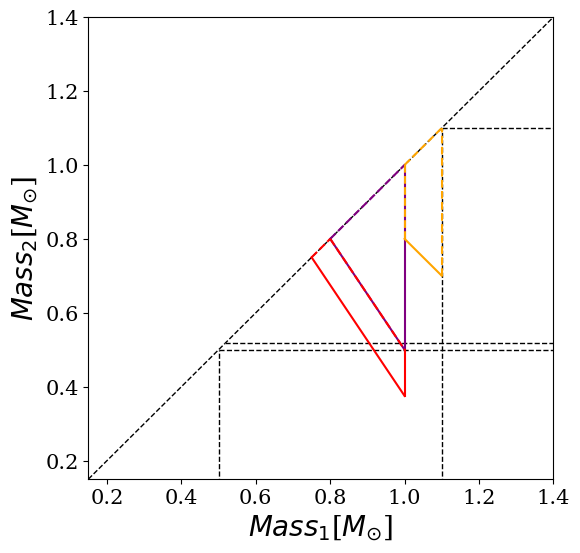

In [ ]:
# change figuresize
fig, ax = plt.subplots(figsize = (6,6))

max_mass_lim = 1.4
plt.ylim(0.15,max_mass_lim)
plt.xlim(0.15,max_mass_lim)

# let's add the mass restrictions for each case of binary WDs as prompted by Shen 2025

xlim = max(M1)
ylim = max(M1)

linecolors = 'black'
linewidths = 1
linecolors_compas = 'black'

plt.axline((0,0), (max(M1),max(M1)), color=linecolors, ls='--', lw=linewidths, transform=plt.gca().transAxes)

#Helium WD cutoff
plt.vlines(x=[0.5], ymin=0, ymax=0.5, colors=linecolors, ls='--', lw=linewidths) # vertical line
plt.plot([0.5,max_mass_lim],[0.5,0.5],color=linecolors,lw=linewidths, ls='--') # horizontal line

# COMPAS HeWD cutoff
plt.vlines(x=[max(mass_hewd_1)], ymin=0, ymax=max(mass_hewd_1), colors=linecolors_compas, ls='--', lw=linewidths) # vertical line
plt.plot([max(mass_hewd_1),max_mass_lim],[max(mass_hewd_1),max(mass_hewd_1)],color=linecolors,lw=linewidths, ls='--') # horizontal line

#Carbon oxygen WD cutoff
plt.vlines(x=[1.1], ymin=0, ymax=1.1, colors=linecolors, ls='--', lw=linewidths) # vertical line
plt.plot([1.1,max_mass_lim],[1.1,1.1],color=linecolors,lw=linewidths, ls='--') # horizontal line

# purple region - 2 star SN Ia
plt.plot([0.8,1],[0.8,0.5],color='purple') # bottom boundary
plt.plot([1.0,1.0],[1.0,0.5],color='purple') # side boundary
plt.plot([0.8,1.0],[0.8,1.0],color='purple',ls='--') # top boundary 


# red region - hypervelocity WDs
plt.plot([0.8,1],[0.8,0.5],color='red',ls='--') # overlapping boundary
plt.plot([0.75,1.0],[0.75,0.375],color='red') # bottom boundary
plt.plot([1.0,1.0],[0.5,0.375],color='red') # side boundary
plt.plot([0.75,0.8],[0.75,0.8],color='red',ls='--') # top boundary
plt.plot([1.1,1.1],[0.7,1.1],color='orange',ls='--') # left side boundary 

# orange region - 2003fg HVS
plt.plot([1.0,1.1],[0.8,0.7],color='orange') # botton boundary
plt.plot([1.0,1.0],[1.0,0.8],color='orange',ls='--') # left side overlapping boundary
plt.plot([1.0,1.1],[1.0,1.1],color='orange',ls='--') # top boundary

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("$Mass_{1}$[$M_{\odot}$]",fontsize=20)
plt.ylabel("$Mass_{2}$[$M_{\odot}$]",fontsize=20)

# increase tick label sizes

## save figure:
# plt.savefig("WDWD_regions_Shen2025criteria.png",bbox_inches='tight',pad_inches=0.1)

#### Tom Wagg KDE Method

In [20]:
## Used from Tom Wagg's LEGWORK Visualization code

from astropy.visualization import quantity_support
import seaborn as sns

def plot_2D_dist(x, y, weights=None, disttype="scatter", fig=None, ax=None, show=True, figsize=(12, 7),
                 xlabel=None, ylabel=None, xlim=None, ylim=None, log_scale=False,
                 color=None, scatter_s=20, **kwargs):
    """Plot a 2D distribution of `x` and `y`

    This function is a wrapper for :func:`matplotlib.pyplot.scatter` and :func:`seaborn.kdeplot`.

    Parameters
    ----------
    x : `float/int array`
        Variable to plot on the x axis, should be a 1D array

    y : `float/int array`
        Variable to plot on the y axis, should be a 1D array

    weights : `float/int array`
        Weights for each variable pair (``x``, ``y``), must have the same shape, good for accounting common and identical systems being plotted w/ KDE

    disttype : `{{ "scatter", "kde" }}`
        Which type of distribution plot to use

    fig: `matplotlib Figure`
        A figure on which to plot the distribution. Both `ax` and `fig` must be supplied for either to be used

    ax: `matplotlib Axis`
        An axis on which to plot the distribution. Both `ax` and `fig` must be supplied for either to be used

    show : `boolean`
        Whether to immediately show the plot or only return the Figure and Axis

    figsize : `tuple`
        Tuple with size for the x- and y-axis if creating a new figure (i.e. ignored when fig/ax is not None)

    xlabel : `string`
        Label for the x axis, passed to Axes.set_xlabel()

    ylabel : `string`
        Label for the y axis, passed to Axes.set_ylabel()

    xlim : `tuple`
        Lower and upper limits for the x axis, passed to Axes.set_xlim()

    ylim : `tuple`
        Lower and upper limits for the u axis, passed to Axes.set_ylim()

    log_scale : `bool or tuple of bools`
        Whether to use a log scale for the axes. A single `bool` is applied to both axes, a tuple is applied
        to the x- and y-axis respectively.

    scatter_s : `float`, default=20
        Scatter point size, passed as ``s`` to a scatter plot and ignored for a KDE

    color : `string or tuple`
        Colour to use for the plot, see https://matplotlib.org/tutorials/colors/colors.html for details on how
        to specify a colour

    **kwargs : `(if disttype=="scatter")`
        Input any of `s, c, marker, cmap, norm, vmin, vmax, alpha, linewidths, edgecolors` or more.
        See :func:`matplotlib.pyplot.scatter` for more details.

    **kwargs : `(if disttype=="kde")`
        Input any of `gridsize, cut, clip, legend, cumulative, cbar, cbar_ax, cbar_kws, bw_method, hue,
        palette, hue_order, hue_norm, levels, thresh, bw_adjust, log_scale, fill, label`.
        See :func:`seaborn.kdeplot` for more details.

    Returns
    -------
    fig : `matplotlib Figure`
        The figure on which the distribution is plotted

    ax : `matplotlib Axis`
        The axis on which the distribution is plotted
    """
    # create new figure and axes is either weren't provided
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # expand log_scale
    if isinstance(log_scale, bool):
        log_scale = (log_scale, log_scale)

    # change default kwargs for matplotlib.scatter
    scatter_args = {}

    # possible kwargs for seaborn.kdeplot
    kde_args = {"gridsize": 200, "legend": True, "levels": 10, "thresh": 0.02}

    # set which ones we are using for this plot
    plot_args = scatter_args if disttype == "scatter" else kde_args

    # update the values with those supplied
    for key, value in kwargs.items():
        plot_args[key] = value

    # create whichever plot was requested
    with quantity_support():
        if disttype == "scatter":
            # change the size of scatter points based on their weights
            if weights is not None:
                scatter_s = weights * scatter_s

            ax.scatter(x, y, s=scatter_s, color=color, **plot_args)

            # apply log scaling to the respective axes
            if log_scale[0]:
                ax.set_xscale("log")
            if log_scale[1]:
                ax.set_yscale("log")
        elif disttype == "kde":
            sns.kdeplot(x=x, y=y, weights=weights, ax=ax, color=color, log_scale=log_scale, **plot_args)

    # update axis labels
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    # update axis limits
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # immediately show the plot if requested
    if show:
        plt.show()

    # return the figure and axis for further plotting
    return fig, ax


In [21]:
# define the detectable parameters
cutoff = 0
detectable_snr = sources.snr[sources.snr > cutoff]
norm = TwoSlopeNorm(vmin=np.log10(np.min(detectable_snr)),
                    vcenter=0, vmax=np.log10(np.max(detectable_snr)))

fig, ax = sources.plot_sources_on_sc(snr_cutoff=cutoff, marker="*", cmap="PuOr_r",
                                     c=np.log10(detectable_snr), show=False, norm=norm, scatter_s=50)

# create a colorbar from the scatter points
cbar = fig.colorbar(ax.collections[1])
cbar.ax.set_ylabel(r"$\log_{10} (\rho)$")

plt.show()

NameError: name 'sources' is not defined

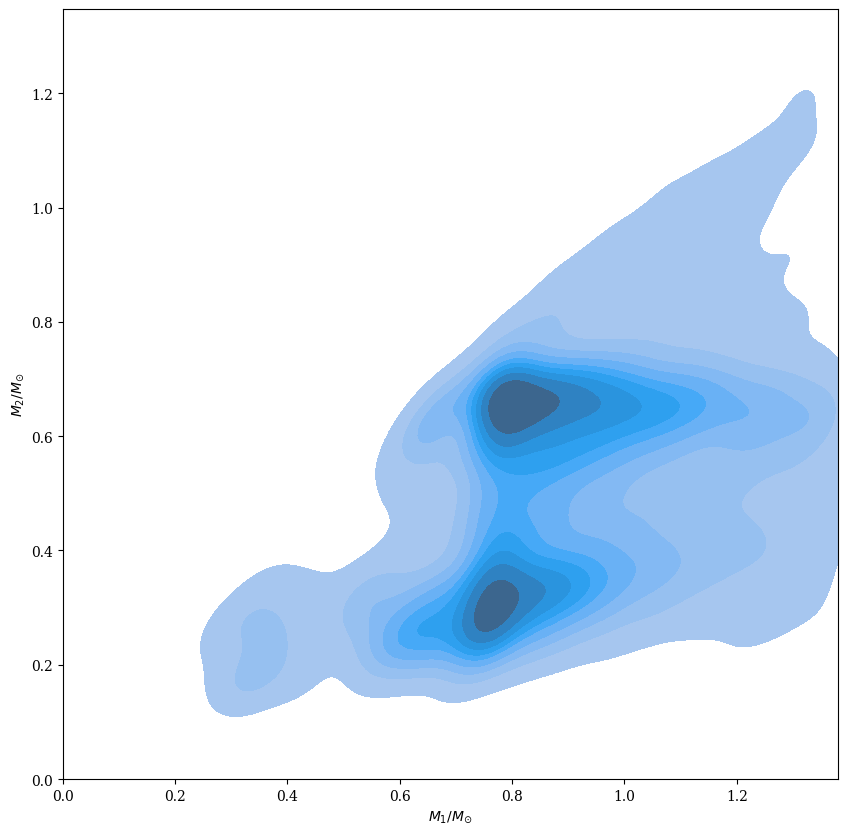

In [29]:
# creating a figure
fig, ax = plt.subplots(figsize=(10, 10))

# add the scatter plot
fig, ax = plot_2D_dist(x=M1, y=M2, fig=fig, ax=ax, disttype="kde", fill=True, xlim=(0, max(M1)), ylim=(0, max(M2)),
                           xlabel="$M_{1}/M_{\odot}$", ylabel="$M_{2}/M_{\odot}$")


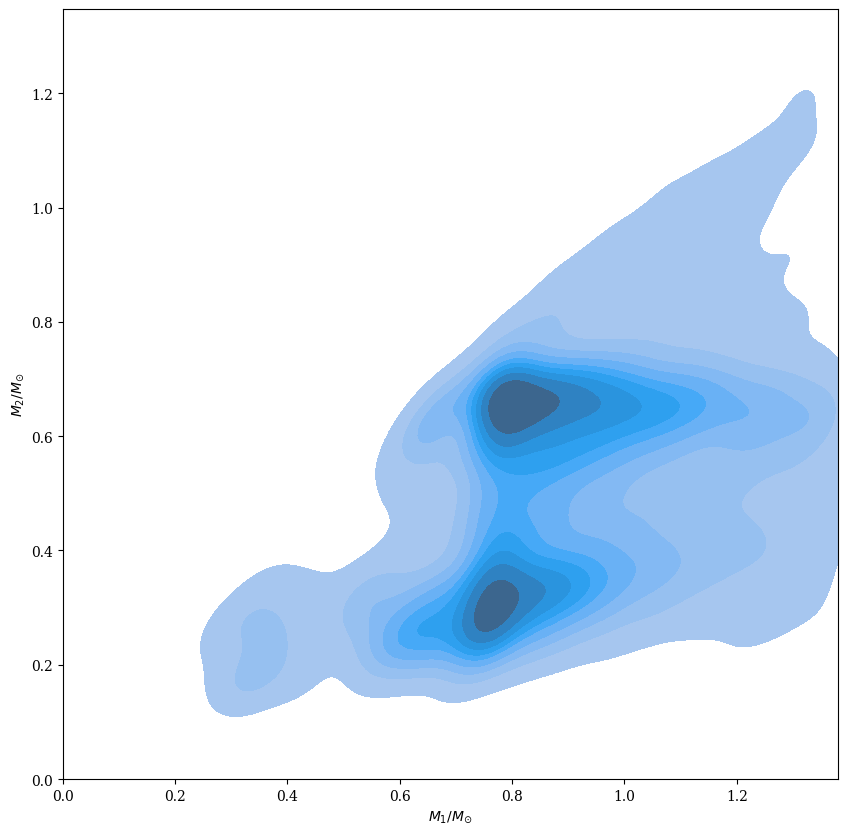

In [22]:
# for the 2D histogram or heatmap, we must consider the rates for each system plotted above

# # let's first define an array of rates 
# rates_systems = np.random.rand(len(M1))#make some numbers up for now until we actually comput the rates 

# let's define what we want to plot and the rates associated with each system 
# cm = plt.cm.get_cmap('RdYlBu')
# sc = plt.scatter(M1, M2, s=rates_z0_WDWD, cmap=cm)

# plt.colorbar(sc, label="Merger Rate [$\mathrm{dNdGpc^{-3}dyr^{-1}}$]")

fig, ax = plt.subplots(figsize=(10, 10))

# add the scatter plot
fig, ax = plot_2D_dist(x=M1, y=M2, fig=fig, ax=ax, disttype="kde", fill=True, xlim=(0, max(M1)), ylim=(0, max(M2)),
                           xlabel="$M_{1}/M_{\odot}$", ylabel="$M_{2}/M_{\odot}$")

# let's add the restrictive lines to the plot
# there should be no plots in the upper left triangle because M1>M2

# ax.axline((0,0), (1.3,1.3), color="black", ls='--', lw = 2, transform=fig.gca().transAxes)

# xlim = 1.3
# ylim = 1.3

# # let's add the mass restrictions for each case of BWD
# #Helium WD cutoff
ax.axvline(x=[0.5], ymin=0, ymax=0.5, color='black', lw=2)
# ax.axhline(y=0.5, color='black', xmin = 0.5/xlim, xmax = 1.3/xlim, ls='--', lw=2) # for axhline, the xmin and mxmax are scale factors of the axis not positions
# #Carbon oxygen WD cutoff
# ax.vlines(x=[1.1], ymin=0, ymax=1.1, colors='black', ls='--', lw=2)
# ax.axhline(y=1.1, color='black', xmin = 1.1/xlim, xmax = 1.3/xlim, ls='--', lw=2)


# # setting the limits of the plot
# ax.xlim(0,xlim)
# ax.ylim(0,ylim)

# # axes labels
# ax.xlabel("$M_{1}/M_{\odot}$")
# ax.ylabel("$M_{2}/M_{\odot}$")

#### Hexagonal Binned Method

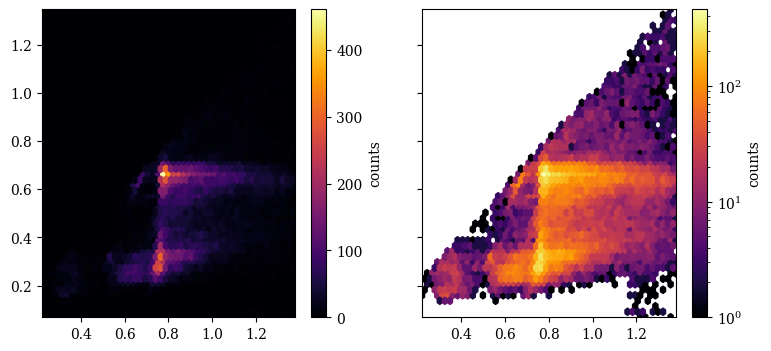

In [23]:
# below is the hexagonal binned method
import matplotlib.pyplot as plt
import numpy as np

fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(9, 4))

xlim = M1.min(), M1.max()
ylim = M2.min(), M2.max()

hb = ax0.hexbin(M1, M2, gridsize=50, cmap='inferno')
ax0.set(xlim=xlim, ylim=ylim)
# ax0.set_title("Hexagon binning")
cb = fig.colorbar(hb, ax=ax0, label='counts')

hb = ax1.hexbin(M1, M2, gridsize=50, bins='log', cmap='inferno')
ax1.set(xlim=xlim, ylim=ylim)
# ax1.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax1, label='counts')

plt.show()

Text(0, 0.5, '$M_{2}/M_{\\odot}$')

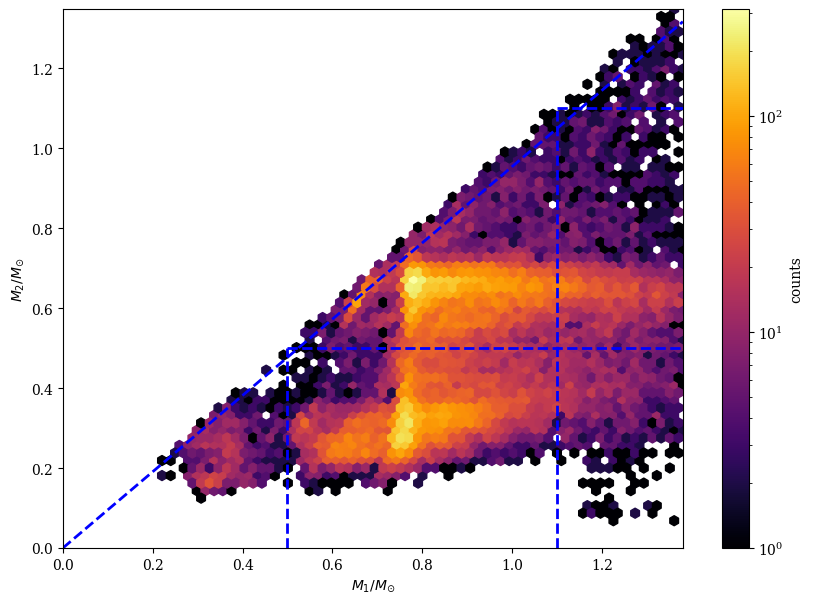

In [74]:
# below is the hexagonal binned method
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(10, 7))

xlim = M1.min(), M1.max()
ylim = M2.min(), M2.max()


# hb = ax1.hexbin(M1, M2, gridsize=60, bins='log', cmap='inferno')
hb = ax1.hexbin(M1, M2, gridsize=60, bins='log',cmap='inferno')
ax1.set(xlim=xlim, ylim=ylim)
# ax1.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax1, label='counts')

xscale = max(M1)
yscale = max(M2)

# let's add the mass restrictions for each case of BWD

plt.axline((0,0), (xscale,yscale), color="blue", ls='--', lw = 2, transform=plt.gca().transAxes)

#Helium WD cutoff
plt.vlines(x=0.5, ymin=0, ymax=0.5, colors='blue', ls='--', lw=2)
plt.axhline(y=0.5, color='blue', xmin = 0.5/xscale, xmax = xscale/xscale, ls='--', lw=2) # for axhline, the xmin and mxmax are scale factors of the axis not positions
#Carbon oxygen WD cutoff
plt.vlines(x=1.1, ymin=0, ymax=1.1, colors='blue', ls='--', lw=2)
plt.axhline(y=1.1, color='blue', xmin = 1.1/xscale, xmax = xscale/xscale, ls='--', lw=2)


# setting the limits of the plot
ax1.set_xlim(0,xscale)
ax1.set_ylim(0,yscale)

# axes labels
ax1.set_xlabel("$M_{1}/M_{\odot}$")
ax1.set_ylabel("$M_{2}/M_{\odot}$")


#### My own method - using 2D Histogram

/tmp/ipykernel_202823/2926948392.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


Text(0, 0.5, '$M_{2}/M_{\\odot}$')

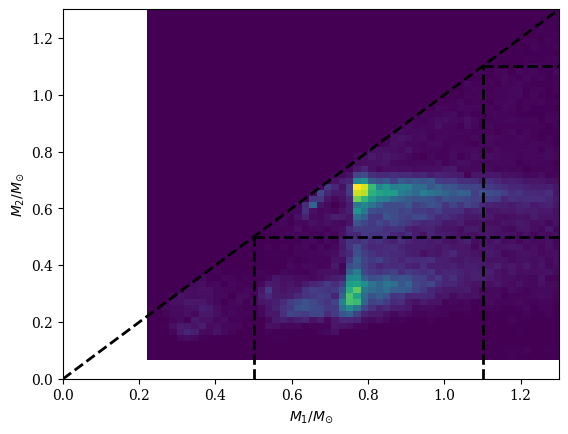

In [12]:
# for the 2D histogram or heatmap, we must consider the rates for each system plotted above

# # let's first define an array of rates 
# rates_systems = np.random.rand(len(M1))#make some numbers up for now until we actually comput the rates 

# let's define what we want to plot and the rates associated with each system 
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.hist2d(M1, M2, bins=60)

# plt.colorbar(sc, label="Count]")

# let's add the restrictive lines to the plot
# there should be no plots in the upper left triangle because M1>M2
xlim = 1.3
ylim = 1.3

plt.axline((0,0), (xlim,ylim), color="black", ls='--', lw = 2, transform=plt.gca().transAxes)

# let's add the mass restrictions for each case of BWD
#Helium WD cutoff
plt.vlines(x=[0.5], ymin=0, ymax=0.5, colors='black', ls='--', lw=2)
plt.axhline(y=0.5, color='black', xmin = 0.5/xlim, xmax = 1.3/xlim, ls='--', lw=2) # for axhline, the xmin and mxmax are scale factors of the axis not positions
#Carbon oxygen WD cutoff
plt.vlines(x=[1.1], ymin=0, ymax=1.1, colors='black', ls='--', lw=2)
plt.axhline(y=1.1, color='black', xmin = 1.1/xlim, xmax = 1.3/xlim, ls='--', lw=2)


# setting the limits of the plot
plt.xlim(0,xlim)
plt.ylim(0,ylim)

# axes labels
plt.xlabel("$M_{1}/M_{\odot}$")
plt.ylabel("$M_{2}/M_{\odot}$")